In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math
import numpy as np
from src.utils.addition_utils import character_level_tokenizer, PositionalEmbedding
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [25]:
dataset_size = 64_000
train_proportion = 0.9

log_interval = 200
batch_size = 64
epochs = 20
learning_rate = 5e-4

In [26]:
def sample_datapoint(number_bits = 3):
    """
    returns a string containing two random numbers on `number_bits` many bits and their sum.
    """
    a_list = [random.randint(0, 9) for _ in range(number_bits)]
    b_list = [random.randint(0, 9) for _ in range(number_bits)]
    a_str = "".join([str(x) for x in a_list])
    b_str = "".join([str(x) for x in b_list])
    sum_int = int(a_str) + int(b_str)
    return (str(a_str) + "+" + str(b_str) + "=", str(sum_int))

sample_datapoint(3)

('729+970=', '1699')

In [27]:
n_digits = 7
data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(n_digits))
data[:4]

[('1348132+2802719=', '4150851'),
 ('5792391+0556715=', '6349106'),
 ('3232858+7692140=', '10924998'),
 ('9378113+4263310=', '13641423')]

In [28]:
data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

len(data_train),len(data_test)

(57600, 6400)

In [29]:
n_digits = 7
tokenizer = character_level_tokenizer()
device = "cuda" if torch.cuda.is_available() else "cpu"
pad_token = '[PAD]'
eos_token = '[EOS]'

class TransformerModel(nn.Transformer):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers):
        super(TransformerModel, self).__init__(d_model=ninp,
                                               nhead=nhead,
                                               dim_feedforward=nhid,
                                               num_encoder_layers=nlayers)
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.pos_encoder = PositionalEmbedding(ninp)
        self.decoder = nn.Linear(ninp, ntoken)

        self.ninp = ninp
        self.global_mask = self.generate_longformer_mask()
        self.init_weights()

    def init_weights(self):
        initrange = 0.01
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def generate_longformer_mask(self, max_len = 100, window_size = 3):
        # Initialize the global mask
        global_mask = torch.zeros([max_len, max_len])
        # Count the number of digits left and right
        nb_left = nb_right = window_size // 2

        total_size = 3 * n_digits + 3
        idx_eq = 2 * n_digits + 1
        idx_plus = n_digits

        # Global attention for '+' and '='
        global_mask[idx_plus, :] = 1
        global_mask[:, idx_plus] = 1
        global_mask[idx_eq, :] = 1
        global_mask[:, idx_eq] = 1

        # Apply sliding window attention for the first total_size tokens
        for i in range(total_size):
            left_token_id = max(0, i - nb_left)
            right_token_id = min(total_size, i + nb_right)
            global_mask[i, left_token_id:right_token_id + 1] = 1

            if i < idx_plus:
                # For tokens before '+', attend to the corresponding window in the second number as well
                global_mask[i, left_token_id + n_digits + 1: right_token_id + n_digits + 2] = 1
            elif i > idx_plus and i < idx_eq:
                # For tokens between '+' and '=', adjust the window index accordingly
                global_mask[i, max(0, left_token_id - n_digits - 1): min(total_size, right_token_id - n_digits)] = 1
            elif i > idx_eq :
                j = i - (idx_eq + 1)  # j ∈ [0, n_digits+1)
                # --- Connexion vers la première opérande ---
                # On mappe j proportionnellement dans [0, n_digits-1].
                first_index = int(j * n_digits / (n_digits + 1))
                start_first = max(0, first_index - nb_left)
                end_first = min(n_digits - 1, first_index + nb_right)
                global_mask[i, start_first:end_first + 1] = 1

                # --- Connexion vers la deuxième opérande ---
                # La deuxième opérande se trouve aux indices [n_digits+1, 2*n_digits]
                second_index = int(j * n_digits / (n_digits + 1))
                start_second = max(idx_plus + 1, (idx_plus + 1) + second_index - nb_left)
                end_second = min(idx_eq - 1, (idx_plus + 1) + second_index + nb_right)
                global_mask[i, start_second:end_second + 1] = 1

                global_mask[i, idx_eq + 1:total_size] = 1

        global_mask = global_mask.masked_fill(global_mask == 0, float('-inf'))
        global_mask = global_mask.masked_fill(global_mask == 1, 0)

        return global_mask


    def _generate_square_subsequent_mask(self, sz):
        # Initialize the mask
        mask = torch.zeros([sz, sz])
        mask = torch.log(torch.tril(torch.ones(sz,sz))) + self.global_mask[:sz, :sz]
        return mask


    def forward(self, src):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        self.src_mask = mask

        src = self.input_emb(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output_enc = self.encoder(src, mask=self.src_mask)
        output_dec = self.decoder(output_enc)
        return F.log_softmax(output_dec, dim=-1), output_enc

In [30]:
model = TransformerModel(ntoken = tokenizer.ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 8).to(device)

model

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=14, bias=True)
  (input_emb): Embedding(14, 128)
  (pos_encoder): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

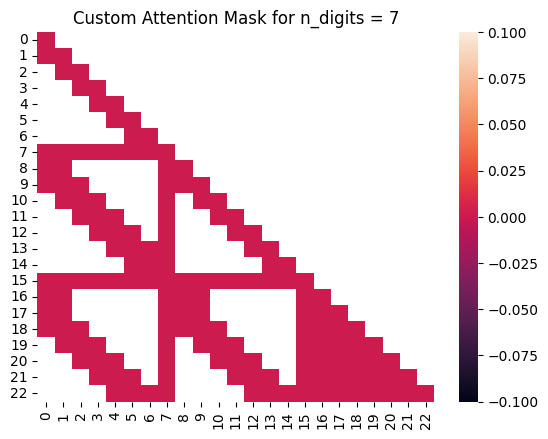

In [31]:
mask = model._generate_square_subsequent_mask(sz = 23)
# Visualize the custom mask
sns.heatmap(mask)
plt.title(f"Custom Attention Mask for n_digits = {7}")
plt.show()

In [32]:
def generate(model, prompts, new_tokens = 8):
    input_tensor = prompts # (length_prompts, batch_size)
    input_tensor = input_tensor.to(device)
    for _ in range(new_tokens):
        output, _ = model(input_tensor) # (length_prompts, batch_size, ntokens)
        last_output = output[-1,:,:] # (batch_size, ntokens)
        token = torch.argmax(last_output, -1).view((1,-1)) # (1, batch_size)
        input_tensor = torch.cat((input_tensor, token), 0)
    return input_tensor

In [33]:
model.eval()

prompt = "1+2="
prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
output = generate(model, prompt_tensor).view((1,-1))
output, tokenizer.decode(output.tolist()[0])

(tensor([[ 1, 10,  2, 11,  2,  2,  2,  2,  2,  2,  2,  2]], device='cuda:0'),
 '1+2=22222222')

In [34]:
def pad(token_list, type_list = "prompts"):
    max_length = max([len(x) for x in token_list])
    out = []
    for x in token_list:
        if type_list == "prompts":
            out.append([tokenizer.token_to_id[pad_token]] * (max_length - len(x)) + x)
        if type_list == "answers":
            out.append(x + [tokenizer.token_to_id[eos_token]] + [tokenizer.token_to_id[pad_token]] * (max_length - len(x)))
    return out, max_length

In [35]:
prompts = [tokenizer.encode("1+1="), tokenizer.encode("21+35=")]
answers = [tokenizer.encode("2"), tokenizer.encode("56")]
padded_prompts, _ = pad(prompts, "prompts")
padded_answers, _ = pad(answers, "answers")
padded_prompts, padded_answers
[tokenizer.decode(p) for p in padded_prompts], [tokenizer.decode(p) for p in padded_answers]

(['[PAD][PAD]1+1=', '21+35='], ['2[EOS][PAD]', '56[EOS]'])

In [36]:
def get_batch(split, i):
    data = data_train if split == 'train' else data_test
    prompts = [tokenizer.encode(data[i][0]) for i in range(i, i + batch_size)]
    padded_prompts, length_prompts = pad(prompts, "prompts")
    answers = [tokenizer.encode(data[i][1]) for i in range(i, i + batch_size)]
    padded_answers, length_answers = pad(answers, "answers")
    X = torch.stack([torch.tensor(x) for x in padded_prompts], 1)
    Y = torch.stack([torch.tensor(x) for x in padded_answers], 1)
    return X, Y, length_prompts, length_answers

X, Y, length_prompts, length_answers = get_batch("train", 243)
X.shape, Y.shape, length_prompts, length_answers

(torch.Size([16, 64]), torch.Size([9, 64]), 16, 8)

In [37]:
def evaluate():
    # Turn on evaluation mode disables dropout.
    model.eval()
    correct = 0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data_test) - 1, batch_size)):
            prompts, target_answers, length_prompts, length_answers = get_batch("test", i)
            prompts = prompts.to(device) # (length_prompts, batch_size)
            target_answers = target_answers.to(device) # (length_answers + 1, batch_size)
            output = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens
            equality_test = answers_tokens == target_answers # (length_answers + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(data_test)
    return accuracy.item()

In [38]:
evaluate()

0.0

In [39]:
ntokens = tokenizer.ntokens

In [40]:
def train_epoch():
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
        prompts, target_answers, length_prompts, length_answers = get_batch("train", i)
        prompts = prompts.to(device) # (length_prompts, batch_size)
        target_answers = target_answers.to(device) # (length_answers, batch_size)
        input_tensor = torch.cat((prompts, target_answers), 0) # (length_prompts + length_answers, batch_size)
        model.zero_grad()
        output, _ = model(input_tensor) # (length_prompts + length_answers, batch_size, ntokens)
        output_answers = output[length_prompts-1:-1,:,:].reshape(-1, ntokens) # (length_answers * batch_size, ntokens)
        target_answers = target_answers.view(-1)
        loss = F.cross_entropy(output_answers, target_answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.2f} | perplexity {:8.2f}'.format(batch, len(data_train) // batch_size,
                                                                                                        elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def train():
    best_test_accuracy = None
    test_accuracy = evaluate()
    print('-' * 89)
    print('| initialisation | test accuracy {:5.2f}'.format(test_accuracy))
    print('-' * 89)
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train_epoch()
        test_accuracy = evaluate()
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | test accuracy {:5.2f}'.format(epoch, (time.time() - epoch_start_time), test_accuracy))
        print('-' * 89)
        # Save the model if the test accuracy is the best we've seen so far.
        if not best_test_accuracy or test_accuracy < best_test_accuracy:
            with open("arithmetic.pt", 'wb') as f:
                torch.save(model, f)
            best_test_accuracy = test_accuracy

In [41]:
train()

-----------------------------------------------------------------------------------------
| initialisation | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   200/  900 batches | ms/batch 23.41 | loss  2.03 | perplexity     7.63
|   400/  900 batches | ms/batch 20.07 | loss  1.81 | perplexity     6.09
|   600/  900 batches | ms/batch 21.82 | loss  1.73 | perplexity     5.67
|   800/  900 batches | ms/batch 21.72 | loss  1.67 | perplexity     5.34
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 24.20s | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   200/  900 batches | ms/batch 22.95 | loss  1.65 | perplexity     5.23
|   400/  900 batches | ms/batch 20.21 | loss  1.63 | perplexity     5.12
|   600/  900 batches | ms/batch 21.91 | loss  1.62 | perplexity     5.07
|   800/  900 batches | ms/

In [44]:
torch.save(model.state_dict,"arithmetic_7_digits.pt")

In [45]:
model.eval()

for i in range(20):
    prompt, answers = data_test[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    output = generate(model, prompt_tensor, len(answers)).view((1,-1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

5297345+0193259=5490604	 actual result: 5490604
7327831+5206318=12534149	 actual result: 12534149
3170738+1392236=4562974	 actual result: 4562974
4275555+1009703=5285258	 actual result: 5285258
4137775+1845158=5982933	 actual result: 5982933
9081762+9862524=18944286	 actual result: 18944286
9446520+5644875=15091395	 actual result: 15091395
4233448+2132402=6365850	 actual result: 6365850
0145530+8308924=8454454	 actual result: 8454454
3681529+4162793=7844322	 actual result: 7844322
1735687+9222890=10958577	 actual result: 10958577
9338808+3797599=13136407	 actual result: 13136407
8316981+6310530=14627511	 actual result: 14627511
8145912+6999679=15145591	 actual result: 15145591
1362265+8116377=9478642	 actual result: 9478642
7427051+6939661=14366712	 actual result: 14366712
4017078+2846309=6863387	 actual result: 6863387
5150020+1529071=6679091	 actual result: 6679091
4852573+6396773=11249346	 actual result: 11249346
5616666+5503942=11120608	 actual result: 11120608
